# knn complete guide
### both sklearn & from scratch
https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import collections

plt.style.use('ggplot')

/Users/jj/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## part 0: load iris

In [2]:
names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
df = pd.read_csv('iris.data', header=None, names=names)
df.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
df['class'].value_counts()

Iris-versicolor    50
Iris-virginica     50
Iris-setosa        50
Name: class, dtype: int64

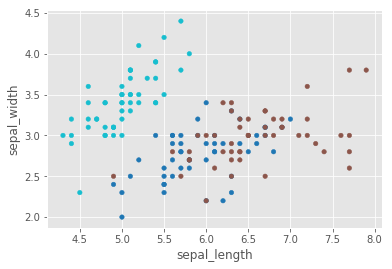

In [4]:
class_maps = {'Iris-versicolor':1,'Iris-virginica':2,'Iris-setosa':3}
df.plot(x='sepal_length', y='sepal_width', 
        kind='scatter', 
        c=df['class'].apply(lambda x: class_maps[x]), 
        colormap='tab10', colorbar=False)

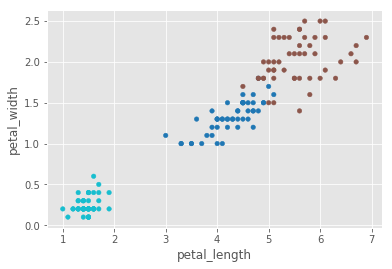

In [5]:
df.plot(x='petal_length', y='petal_width', 
        kind='scatter', 
        c=df['class'].apply(lambda x: class_maps[x]), 
        colormap='tab10', colorbar=False)

In [6]:
X = np.array(df.ix[:, 0:4])
y = np.array(df['class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)
print(len(X_train), len(X_test), len(y_train), len(y_test))

100 50 100 50


/Users/jj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


## part 1: sklearn implementation

In [7]:
%%time
#
### try with k=3 initially
#

#instantiate
knn = KNeighborsClassifier(n_neighbors=3)
#fit
knn.fit(X_train, y_train)
#predict
pred = knn.predict(X_test)

#eval
print('Test Accuracy =', accuracy_score(y_test, pred))

Test Accuracy = 0.98
CPU times: user 2.66 ms, sys: 1.92 ms, total: 4.58 ms
Wall time: 4.67 ms


In [8]:
%help

UsageError: Line magic function `%help` not found.


In [9]:
%%time
#
### 10-fold cross validation across range of k
#

# list of odd k options
k_options = list(filter(lambda x: (x%2 != 0), list(range(1,50))))

# 10-fold across k_options
cv_scores = []
for k in k_options:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    print(k, ' = ', scores.mean())
    cv_scores.append(scores.mean())

1  =  0.9425252525252527
3  =  0.9432828282828283
5  =  0.9516161616161616
7  =  0.9525252525252526
9  =  0.9441919191919192
11  =  0.9425252525252527
13  =  0.9341919191919192
15  =  0.9425252525252527
17  =  0.9425252525252527
19  =  0.9425252525252527
21  =  0.9425252525252527
23  =  0.9314141414141416
25  =  0.9505050505050505
27  =  0.9121212121212121
29  =  0.9091919191919192
31  =  0.891010101010101
33  =  0.9001010101010103
35  =  0.9091919191919192
37  =  0.9001010101010103
39  =  0.8917676767676769
41  =  0.902878787878788
43  =  0.8917676767676769
45  =  0.8826767676767677
47  =  0.8826767676767678
49  =  0.8715656565656567
CPU times: user 332 ms, sys: 45.3 ms, total: 378 ms
Wall time: 339 ms


optimal k = 7 with MSE = 0.04747474747474745


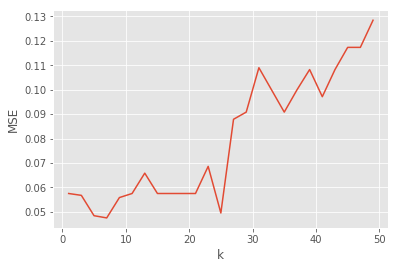

In [10]:
# calc misclassification error
MSE = [1-x for x in cv_scores]

# get optimal k
optimal_k = k_options[MSE.index(min(MSE))]
print('optimal k =', optimal_k, 'with MSE =', min(MSE))

#plot
plt.plot(k_options, MSE)
plt.xlabel('k')
plt.ylabel('MSE')
plt.show()

## part 2: implement from scratch

In [11]:
class KNN():
    
    def train(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        return
    
    def predict_single_obs(self, X_test_obs, k):
        # calc distances
        distances = []
        targets = []
        for i in range(len(self.X_train)):
            dist = np.sqrt(np.sum(np.square(X_test_obs - self.X_train[i, :])))
            distances.append([dist, i])
        
        # sort & target
        distances = sorted(distances)
        for i in range(k):
            targets.append(self.y_train[distances[i][1]])
            
        # return most common
        c = collections.Counter(targets)
        return c.most_common(1)[0][0]
    
    def predict(self, X_test, k):
        if k > len(self.X_train):
            raise ValueError('cant have k > training samples')
        
        predictions = []
        for i in range(len(X_test)):
            predictions.append(self.predict_single_obs(X_test[i, :], k))
            
        return predictions

In [12]:
#train
knn_scratch = KNN()
knn_scratch.train(X_train, y_train)

#predict w/ k=3
predictions = knn_scratch.predict(X_test, 3)

print(predictions)
print('Test Accuracy =', accuracy_score(y_test, predictions))

['Iris-versicolor', 'Iris-setosa', 'Iris-virginica', 'Iris-versicolor', 'Iris-versicolor', 'Iris-setosa', 'Iris-versicolor', 'Iris-virginica', 'Iris-versicolor', 'Iris-versicolor', 'Iris-virginica', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-versicolor', 'Iris-virginica', 'Iris-versicolor', 'Iris-versicolor', 'Iris-virginica', 'Iris-setosa', 'Iris-virginica', 'Iris-setosa', 'Iris-virginica', 'Iris-virginica', 'Iris-virginica', 'Iris-virginica', 'Iris-virginica', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-versicolor', 'Iris-setosa', 'Iris-setosa', 'Iris-virginica', 'Iris-versicolor', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-virginica', 'Iris-versicolor', 'Iris-versicolor', 'Iris-setosa', 'Iris-setosa', 'Iris-versicolor', 'Iris-versicolor', 'Iris-virginica', 'Iris-versicolor', 'Iris-virginica']
Test Accuracy = 0.98
